- **Date:** 2019-6-3
- **Author:** Zhanyuan Zhang
- **Purpose:** 
    - Reproduce the plot of validation accuracy v.s. threshold value on subset (1,000/50,000) of ImageNet validation data set.

In [0]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/dl-security/') #Change the path to the directory that contains all code and data

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#!pip install https://github.com/bethgelab/foolbox/archive/master.zip

In [11]:
from bagnets.utils import plot_heatmap, generate_heatmap_pytorch
from bagnets.utils import pad_image, convert2channel_last, imagenet_preprocess, extract_patches, bagnet_predict, compare_heatmap
from bagnets.utils import bagnet33_debug, plot_saliency, compute_saliency_map
from bagnets.utils import get_topk_acc, validate
from bagnets.utils import bagnet_patch_predict, get_heatmap
from bagnets.clipping import*
from foolbox.utils import samples
import bagnets.pytorch
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import time
import os
import cv2
img_path = "./ILSVRC2012_img_val"
root = "./"
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
if use_cuda:
    print(torch.cuda.get_device_name(0))

Tesla T4


In [5]:
# load pretrained model
bagnet33 = bagnets.pytorch.bagnet33(pretrained=True, avg_pool=False).to(device)
bagnet33.eval()
print()

In [0]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
imagenet_transform = transforms.Compose([transforms.Resize(256), 
                                          transforms.CenterCrop(224), 
                                          transforms.ToTensor(), 
                                          normalize])
imagenet_val = datasets.ImageNet('./', split='val', download=False, 
                                 transform=imagenet_transform)

In [0]:
val_subset_indices = np.random.choice(np.arange(50000), size=1000, replace=False)
val_subset_loader = torch.utils.data.DataLoader(imagenet_val, 
                                                batch_size=128,
                                                sampler=torch.utils.data.sampler.SubsetRandomSampler(val_subset_indices))

In [18]:
clip_below_acc = []
for thresh in range(-100, 101, 25):
    print("Threshold: {}".format(thresh))
    step_acc = validate(val_subset_loader, bagnet33, device, clip = clip_below, a = thresh)
    clip_below_acc.append(step_acc)

Threshold: -100
Iteration 0, validation accuracy: 0.789, time: 0.007718563079833984s
Iteration 1, validation accuracy: 0.852, time: 0.0075452327728271484s
Iteration 2, validation accuracy: 0.867, time: 0.007692098617553711s
Iteration 3, validation accuracy: 0.883, time: 0.007752656936645508s
Iteration 4, validation accuracy: 0.914, time: 0.007592201232910156s
Iteration 5, validation accuracy: 0.805, time: 0.007559061050415039s
Iteration 6, validation accuracy: 0.891, time: 0.0077190399169921875s
Iteration 7, validation accuracy: 0.856, time: 0.0080108642578125s
Validation accuracy: 0.857, validation time: 0.06, total time: 23.35s
Threshold: -75
Iteration 0, validation accuracy: 0.844, time: 0.007696390151977539s
Iteration 1, validation accuracy: 0.867, time: 0.0074999332427978516s
Iteration 2, validation accuracy: 0.852, time: 0.007612705230712891s
Iteration 3, validation accuracy: 0.844, time: 0.007713794708251953s
Iteration 4, validation accuracy: 0.859, time: 0.00828695297241211s
It

In [13]:
binarize_acc = []
for thresh in range(-100, 101, 25):
    print("Threshold: {}".format(thresh))
    step_acc = validate(val_subset_loader, bagnet33, device, clip = binarize, a = thresh)
    binarize_acc.append(step_acc)

Threshold: -100
Iteration 0, validation accuracy: 0.000, time: 0.007660865783691406s
Iteration 1, validation accuracy: 0.008, time: 0.007865428924560547s
Iteration 2, validation accuracy: 0.000, time: 0.0075833797454833984s
Iteration 3, validation accuracy: 0.008, time: 0.007809162139892578s
Iteration 4, validation accuracy: 0.000, time: 0.00780487060546875s
Iteration 5, validation accuracy: 0.000, time: 0.007682323455810547s
Iteration 6, validation accuracy: 0.008, time: 0.00760197639465332s
Iteration 7, validation accuracy: 0.000, time: 0.0077190399169921875s
Validation accuracy: 0.003, validation time: 0.06, total time: 23.81s
Threshold: -75
Iteration 0, validation accuracy: 0.000, time: 0.007830619812011719s
Iteration 1, validation accuracy: 0.008, time: 0.007853507995605469s
Iteration 2, validation accuracy: 0.008, time: 0.007957696914672852s
Iteration 3, validation accuracy: 0.008, time: 0.007818460464477539s
Iteration 4, validation accuracy: 0.000, time: 0.00757908821105957s
Ite

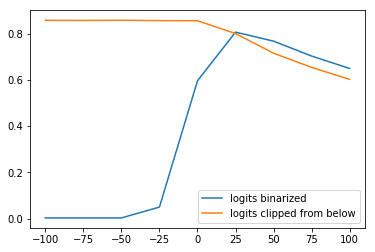

In [20]:
plt.plot(np.arange(-100, 101, 25), binarize_acc, label = "logits binarized")
plt.plot(np.arange(-100, 101, 25), clip_below_acc, label = "logits clipped from below")
plt.legend()